In [ ]:
import numpy as np
from scipy.optimize import minimize, Bounds, NonlinearConstraint, LinearConstraint

N, dt = 100, 60.0
V0, T0, V_ref = 40.0, 20.0, 30.0
Tb, a, beta, b = 100.0, 10.0, 0.1/3600.0, 10.0
rho_mos, cp_mos, C_rec = 1.0, 4180.0, 6e4
rho_w, h_fg, eta = 0.958, 2.257e6, 1.0#0.85
P_max, T_min, T_max = 6e3, 20.0, 100.0
w1, w2, w3 = 0.0, 0.0, 1e0
epsilon = 1e-6

# def sigma(T): return 0.0
def sigma(T): return 1.0/(1.0+np.exp(-a*(T-Tb)))

def sigma_P(P): return P/(P + epsilon)
# def sigma_P(P): return 1.0/(1.0+np.exp(-b*P))

def unpack(x):
    P = x[:N]
    T = np.empty(N+1); T = x[N:N+N]
    V = np.empty(N+1); V = x[N+N:]
    return P, T, V

def objective(x):
    P, T, V = unpack(x)
    # print(V.shape, np.full(N, V_ref).shape)
    return np.sum(T-np.full(N, Tb))**2
    # return w1*np.sum(V[-30:]-np.full(30, V_ref))**2 + w2*np.sum(P) + w3*1/N*np.sum(T[1:]-np.full(N, Tb))**2
    # return w1*(V[-1]-V_ref)**2 + w2*np.sum(P)*dt

# Equality constraints stacked for all k
def volume_residual(x):
    P, T, V = unpack(x)
    res = np.empty(N)
    for k in range(N):
        res[k] = V[k+1] - V[k]*np.exp(-beta*sigma(T[k])*sigma_P(P[k])*dt)
    return res

def energy_residual(x):
    P, T, V = unpack(x)
    res = np.empty(N-1)
    for k in range(N-1):
        # Vbar = V[k]  # or 0.5*(V[k]+V[k+1])
        sensible = (rho_mos*cp_mos*V0 + C_rec)*(T[k+1]-T[k])
        # latent   = rho_w*h_fg*(V[k]-V[k+1])
        res[k]   = eta*P[k]*dt - (sensible )#+ latent)
    return res

def temperature_initial(x):
    P, T, V = unpack(x)
    return T[0] - T0

def volume_initial(x):
    P, T, V = unpack(x)
    return V - V0
    # return V[0] - V0


cons = [
    # NonlinearConstraint(volume_residual, 0.0, 0.0),
    # NonlinearConstraint(energy_residual, 0.0, 0.0),
    {'type': 'eq',
    'fun': energy_residual},
    {'type': 'eq',
    'fun': temperature_initial},
    # {'type': 'eq',
    # 'fun': volume_initial},
    # Temperature bounds at all nodes:
    # NonlinearConstraint(lambda x: unpack(x)[1],
    #                     lb=T_min*np.ones(N+1),
    #                     ub=T_max*np.ones(N+1)),
    # # Volume nonnegativity:
    # NonlinearConstraint(lambda x: unpack(x)[2],
    #                     lb=1e-6*np.ones(N+1), ub=np.inf*np.ones(N+1)),
]


# Bounds for decisions: [P_0..P_{N-1}, T_1..T_N, V_1..V_N]
lb = np.concatenate([np.zeros(N),      T_min*np.ones(N),  -np.inf*np.ones(N)])
ub = np.concatenate([P_max*np.ones(N), T_max*np.ones(N),  np.inf*np.ones(N)])
bounds = Bounds(lb, ub)

# Feasible initial guess: forward simulate with constant P
P0 = np.full(N, 1.0*P_max)
# simple forward pass to build consistent T,V
Tg = np.empty(N); Vg = np.empty(N); Tg[0]=T0; Vg[0]=V0
for k in range(N-1):
    Vg[k+1] = Vg[k]*np.exp(-beta*sigma(Tg[k])*sigma_P(P0[k])*dt)
    Ceff = rho_mos*cp_mos*Vg[k] + C_rec
    Tg[k+1] = Tg[k] + (eta*P0[k]*dt )/Ceff#- rho_w*h_fg*(Vg[k]-Vg[k+1]))/Ceff

x0 = np.concatenate([P0, Tg, Vg])

res = minimize(objective, x0, method='trust-constr',
               bounds=bounds, constraints=cons,
               options=dict(verbose=3, maxiter=500))

print("Status:", res.message)
P_opt, T_opt, V_opt = unpack(res.x)
print(f"V_N={V_opt[-1]:.2f} L, T_max={T_opt.max():.2f} °C, P̄={P_opt.mean():.0f} W")

C:\Users\leomc\AppData\Local\Temp\ipykernel_32756\649585664.py:14: RuntimeWarning: overflow encountered in exp
  def sigma(T): return 1.0/(1.0+np.exp(-a*(T-Tb)))
c:\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  301  |   0   | +1.4532e+04 | 1.00e+00 | 3.10e+00 | 2.11e+04 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  602  |   1   | +1.4539e+04 | 7.00e+00 | 2.86e+00 | 2.06e+04 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  903  |   4   | +1.4488e+04 | 3.06e+01 | 1.18e+00 | 2.01e+04 | 1.00e+00 |  1.00e-01   |   4   |
|   4   | 1204  |  10   | +1.4397e+04 | 4.58e+01 | 5.53e-01 | 1.96e+04 | 1.00e+00 |  1.00e-01   |   4   |
|   5   | 1505  |  96   | +1.4379e+04 | 4.58e+01 | 4.61e-01 | 1.91e+04 | 1.00e+00 |  1.00e-01   |   4   |
|   6   | 1806  |  176  | +1.4380e+04 | 1.43e+02 | 4.43e-01 | 1.90e+04 | 1.00e+00 |  1.00e-01   |   4   |
|   7   | 2107  |  285  | +1.4374e+04 | 9.69e+02 | 4.17e-01 | 1.86e+04 | 1.00e+00 |  1.00e-01   |   2   |
|   8   | 2408  |  427  | +1.4371e+04 | 2.20e+

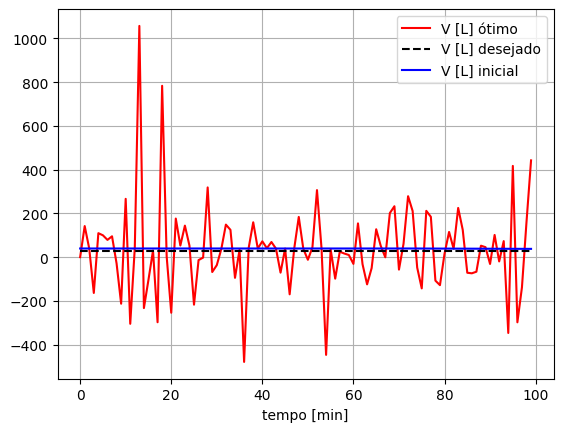

In [ ]:
# %matplotlib inline
# Caso queira ver as três séries:
import matplotlib.pyplot as plt
t = np.arange(N)*dt/60.0   # minutos
plt.plot(t, V_opt, color='red', label='V [L] ótimo')
plt.plot(t, np.full(V_opt.shape, V_ref), '--',color='black', label='V [L] desejado')
plt.plot(t, Vg, color='blue', label='V [L] inicial')
# plt.plot(t, T_opt, label='T [°C]')
plt.legend(); plt.xlabel('tempo [min]'); plt.grid(True); plt.show()

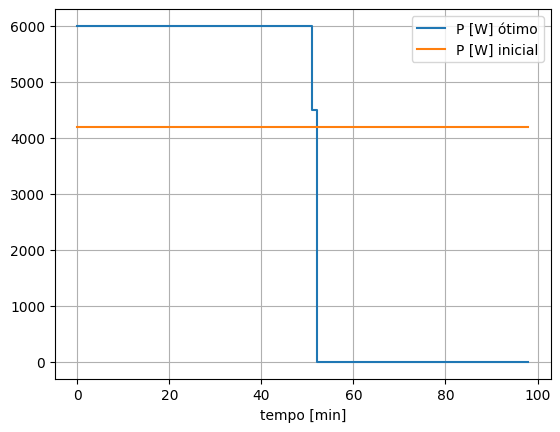

In [ ]:
plt.step(t[:-1], P_opt[:-1], where='post', label='P [W] ótimo')
plt.step(t[:-1], P0[:-1], where='post', label='P [W] inicial')
plt.legend(); plt.xlabel('tempo [min]'); plt.grid(True); plt.show()


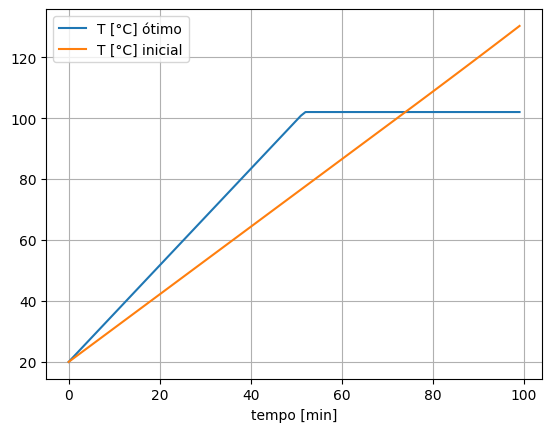

In [ ]:
# %matplotlib inline
plt.plot(t, T_opt, label='T [°C] ótimo')
plt.plot(t, Tg, label='T [°C] inicial')
plt.legend(); plt.xlabel('tempo [min]'); plt.grid(True); plt.show()